# ResNet-50 Models

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers as tkl
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [3]:
X_train = X_train / 255
X_test = X_test / 255

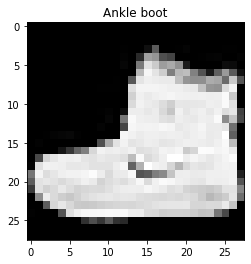

In [4]:
plt.imshow(X_train[0], cmap = "Greys_r")
plt.title(classes[y_train[0]])
plt.show()

In [5]:
def residual_block(X, concat, filters, kernel_size):
    conv3x3_v1 = tkl.Conv2D(filters, kernel_size = kernel_size, strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(X)
    conv3x3_v2 = tkl.Conv2D(filters, kernel_size = kernel_size, strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(conv3x3_v1)
    output = tkl.Concatenate(axis = 3)([conv3x3_v2, concat])
    return output, conv3x3_v2

### 1. ResNet Model v1 - 2

In [6]:
def resnet_v1():
    input_layer = keras.Input(shape = (28, 28, 1), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R3)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv1")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [7]:
resnet_v1 = resnet_v1()

Metal device set to: Apple M1 Pro


2022-10-25 17:52:33.501161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 17:52:33.501280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
history = resnet_v1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 3)

Epoch 1/3


2022-10-25 17:52:33.729091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 17:52:34.015653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1873/1875 [============================>.] - ETA: 0s - loss: 0.6961 - accuracy: 0.7478

2022-10-25 17:53:12.754677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 43s 23ms/step - loss: 0.6958 - accuracy: 0.7479 - val_loss: 0.4757 - val_accuracy: 0.8376
Epoch 2/3
1875/1875 [==============================] - 44s 24ms/step - loss: 0.4188 - accuracy: 0.8496 - val_loss: 0.3818 - val_accuracy: 0.8670
Epoch 3/3
1875/1875 [==============================] - 43s 23ms/step - loss: 0.3485 - accuracy: 0.8746 - val_loss: 0.3377 - val_accuracy: 0.8801


In [9]:
predictions = resnet_v1.predict(X_test)

 14/313 [>.............................] - ETA: 2s

2022-10-25 17:54:44.075340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 10ms/step


In [10]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

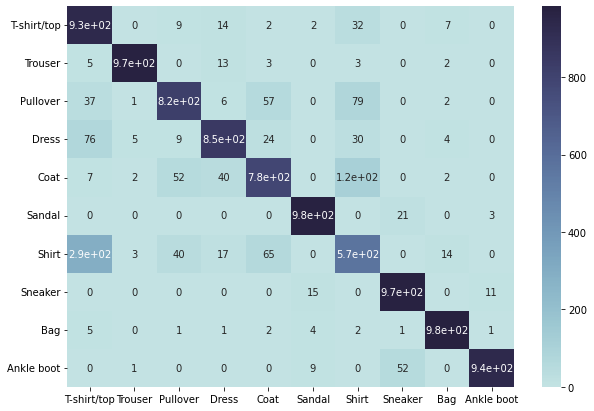

In [11]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

### 2. ResNet Model v2 - 4

In [12]:
def resnet_v2():
    input_layer = keras.Input(shape = (28, 28, 1), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P2 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R3)
    
    R4, A4 = residual_block(P2, P2, 128, (3, 3))
    R5, A5 = residual_block(R4, A4, 128, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R5)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv2")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [13]:
resnet_v2 = resnet_v2()

In [14]:
history = resnet_v2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 3)

Epoch 1/3


2022-10-25 17:54:48.406416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 0.5410 - accuracy: 0.8004

2022-10-25 17:55:43.936560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 61s 32ms/step - loss: 0.5409 - accuracy: 0.8004 - val_loss: 0.3423 - val_accuracy: 0.8782
Epoch 2/3
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2895 - accuracy: 0.8947 - val_loss: 0.2793 - val_accuracy: 0.8982
Epoch 3/3
1875/1875 [==============================] - 61s 32ms/step - loss: 0.2356 - accuracy: 0.9139 - val_loss: 0.2639 - val_accuracy: 0.9052


In [15]:
predictions = resnet_v2.predict(X_test)

 10/313 [..............................] - ETA: 3s

2022-10-25 17:57:46.083423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 5s 15ms/step


In [16]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

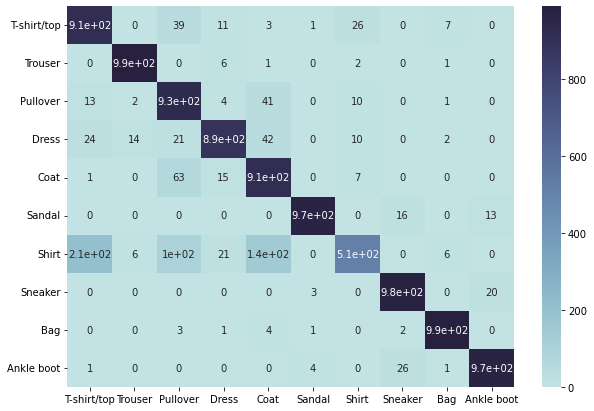

In [17]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

### 3. ResNet Model v3 - 6

In [18]:
def resnet_v3():
    input_layer = keras.Input(shape = (28, 28, 1), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P2 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R3)
    
    R4, A4 = residual_block(P2, P2, 128, (3, 3))
    R5, A5 = residual_block(R4, A4, 128, (3, 3))
    
    P3 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R5)
    
    R6, A6 = residual_block(P3, P3, 256, (3, 3))
    R7, A7 = residual_block(R6, A6, 256, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R7)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv3")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [19]:
resnet_v3 = resnet_v3()

In [20]:
history = resnet_v3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 3)

Epoch 1/3


2022-10-25 17:57:51.726447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1874/1875 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.8133

2022-10-25 17:59:10.803466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 86s 45ms/step - loss: 0.5051 - accuracy: 0.8133 - val_loss: 0.3221 - val_accuracy: 0.8784
Epoch 2/3
1875/1875 [==============================] - 87s 47ms/step - loss: 0.2724 - accuracy: 0.9000 - val_loss: 0.2542 - val_accuracy: 0.9072
Epoch 3/3
1875/1875 [==============================] - 88s 47ms/step - loss: 0.2211 - accuracy: 0.9182 - val_loss: 0.2577 - val_accuracy: 0.9095


In [21]:
predictions = resnet_v3.predict(X_test)

  4/313 [..............................] - ETA: 5s 

2022-10-25 18:02:12.710220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 6s 19ms/step


In [22]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

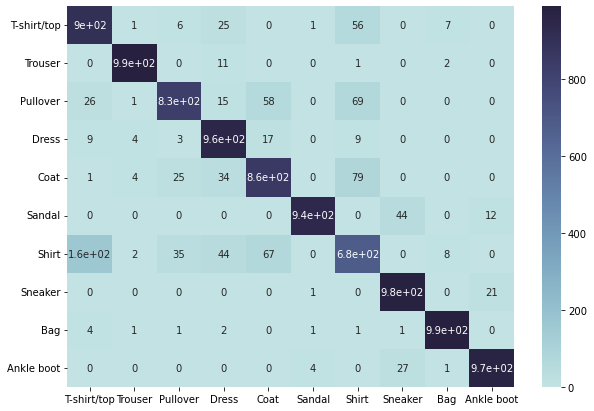

In [23]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

### 4. ResNet Model v4 - 8

In [28]:
def resnet_v4():
    input_layer = keras.Input(shape = (28, 28, 1), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P2 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R3)
    
    R4, A4 = residual_block(P2, P2, 128, (3, 3))
    R5, A5 = residual_block(R4, A4, 128, (3, 3))
    
    P3 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R5)
    
    R6, A6 = residual_block(P3, P3, 256, (3, 3))
    R7, A7 = residual_block(R6, A6, 256, (3, 3))
    
    P4 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R7)
    
    R8, A8 = residual_block(P4, P4, 512, (3, 3))
    R9, A9 = residual_block(R8, A8, 512, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R9)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv4")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [29]:
resnet_v4 = resnet_v4()

In [31]:
history = resnet_v4.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20


2022-10-25 18:03:01.955785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7972

2022-10-25 18:04:54.221739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 119s 63ms/step - loss: 0.6333 - accuracy: 0.7972 - val_loss: 0.3590 - val_accuracy: 0.8690
Epoch 2/20
1875/1875 [==============================] - 116s 62ms/step - loss: 0.2968 - accuracy: 0.8907 - val_loss: 0.2877 - val_accuracy: 0.8950
Epoch 3/20
1875/1875 [==============================] - 116s 62ms/step - loss: 0.2506 - accuracy: 0.9081 - val_loss: 0.2507 - val_accuracy: 0.9083
Epoch 4/20
1875/1875 [==============================] - 108s 57ms/step - loss: 0.2195 - accuracy: 0.9192 - val_loss: 0.2426 - val_accuracy: 0.9108
Epoch 5/20
1875/1875 [==============================] - 108s 57ms/step - loss: 0.1970 - accuracy: 0.9272 - val_loss: 0.2488 - val_accuracy: 0.9054
Epoch 6/20
1875/1875 [==============================] - 108s 58ms/step - loss: 0.1819 - accuracy: 0.9322 - val_loss: 0.2551 - val_accuracy: 0.9094
Epoch 7/20
 332/1875 [====>.........................] - ETA: 1:23 - loss: 0.1643 - accuracy: 0.9404

KeyboardInterrupt: 

In [32]:
predictions = resnet_v4.predict(X_test)

  1/313 [..............................] - ETA: 1:15

2022-10-25 18:14:48.220531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 5s 16ms/step


In [33]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

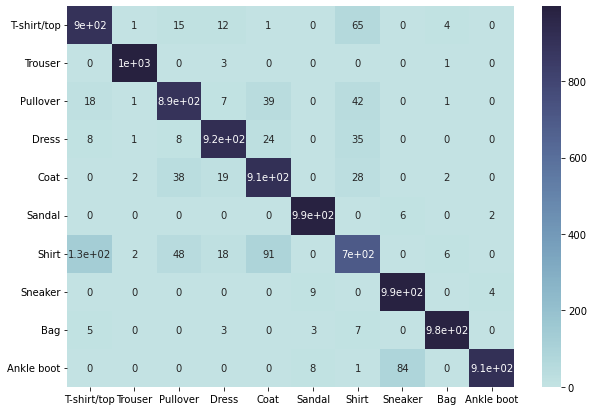

In [34]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()